# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE
# from PCAfold         import PCA          as PCAA


import romnet                            as rmnt


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/PDFEvolve_10Cases/')

path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/PDFEvolve_10Cases/DeepONet/Run_1/')

FigDir           = os.path.join(WORKSPACE_PATH, '../Desktop/Figures_PDFEvolve/')


# DataType         = 'train'
# CasesVec         = range(0,500,100)
DataType         = 'test'
CasesVec         = range(10) #[1,0,2]

NVars            = 50
NSamples         = 1

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/PDFEvolve/DeepONet/../../../../../../ROMNet/PDFEvolve_10Cases/DeepONet/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.architecture, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x16bb85fa0>, <keras.layers.core.dense.Dense object at 0x16bb7fcd0>, <keras.layers.core.dense.Dense object at 0x16ba83700>])
[ROMNet - component.py              ]:       Constructing Component: Branch_2
[ROMNet - sub_component.py      

## Evaluating DeepONet on Test Data

### Loading Simulations Info

In [5]:
x_names   = ['x_'+str(i+1) for i in range(NVars)] 
x0_names  = ['x0_'+str(i+1) for i in range(NVars)] 

InputVars = x0_names+['t']

x         = np.linspace(-2.,2.,NVars)

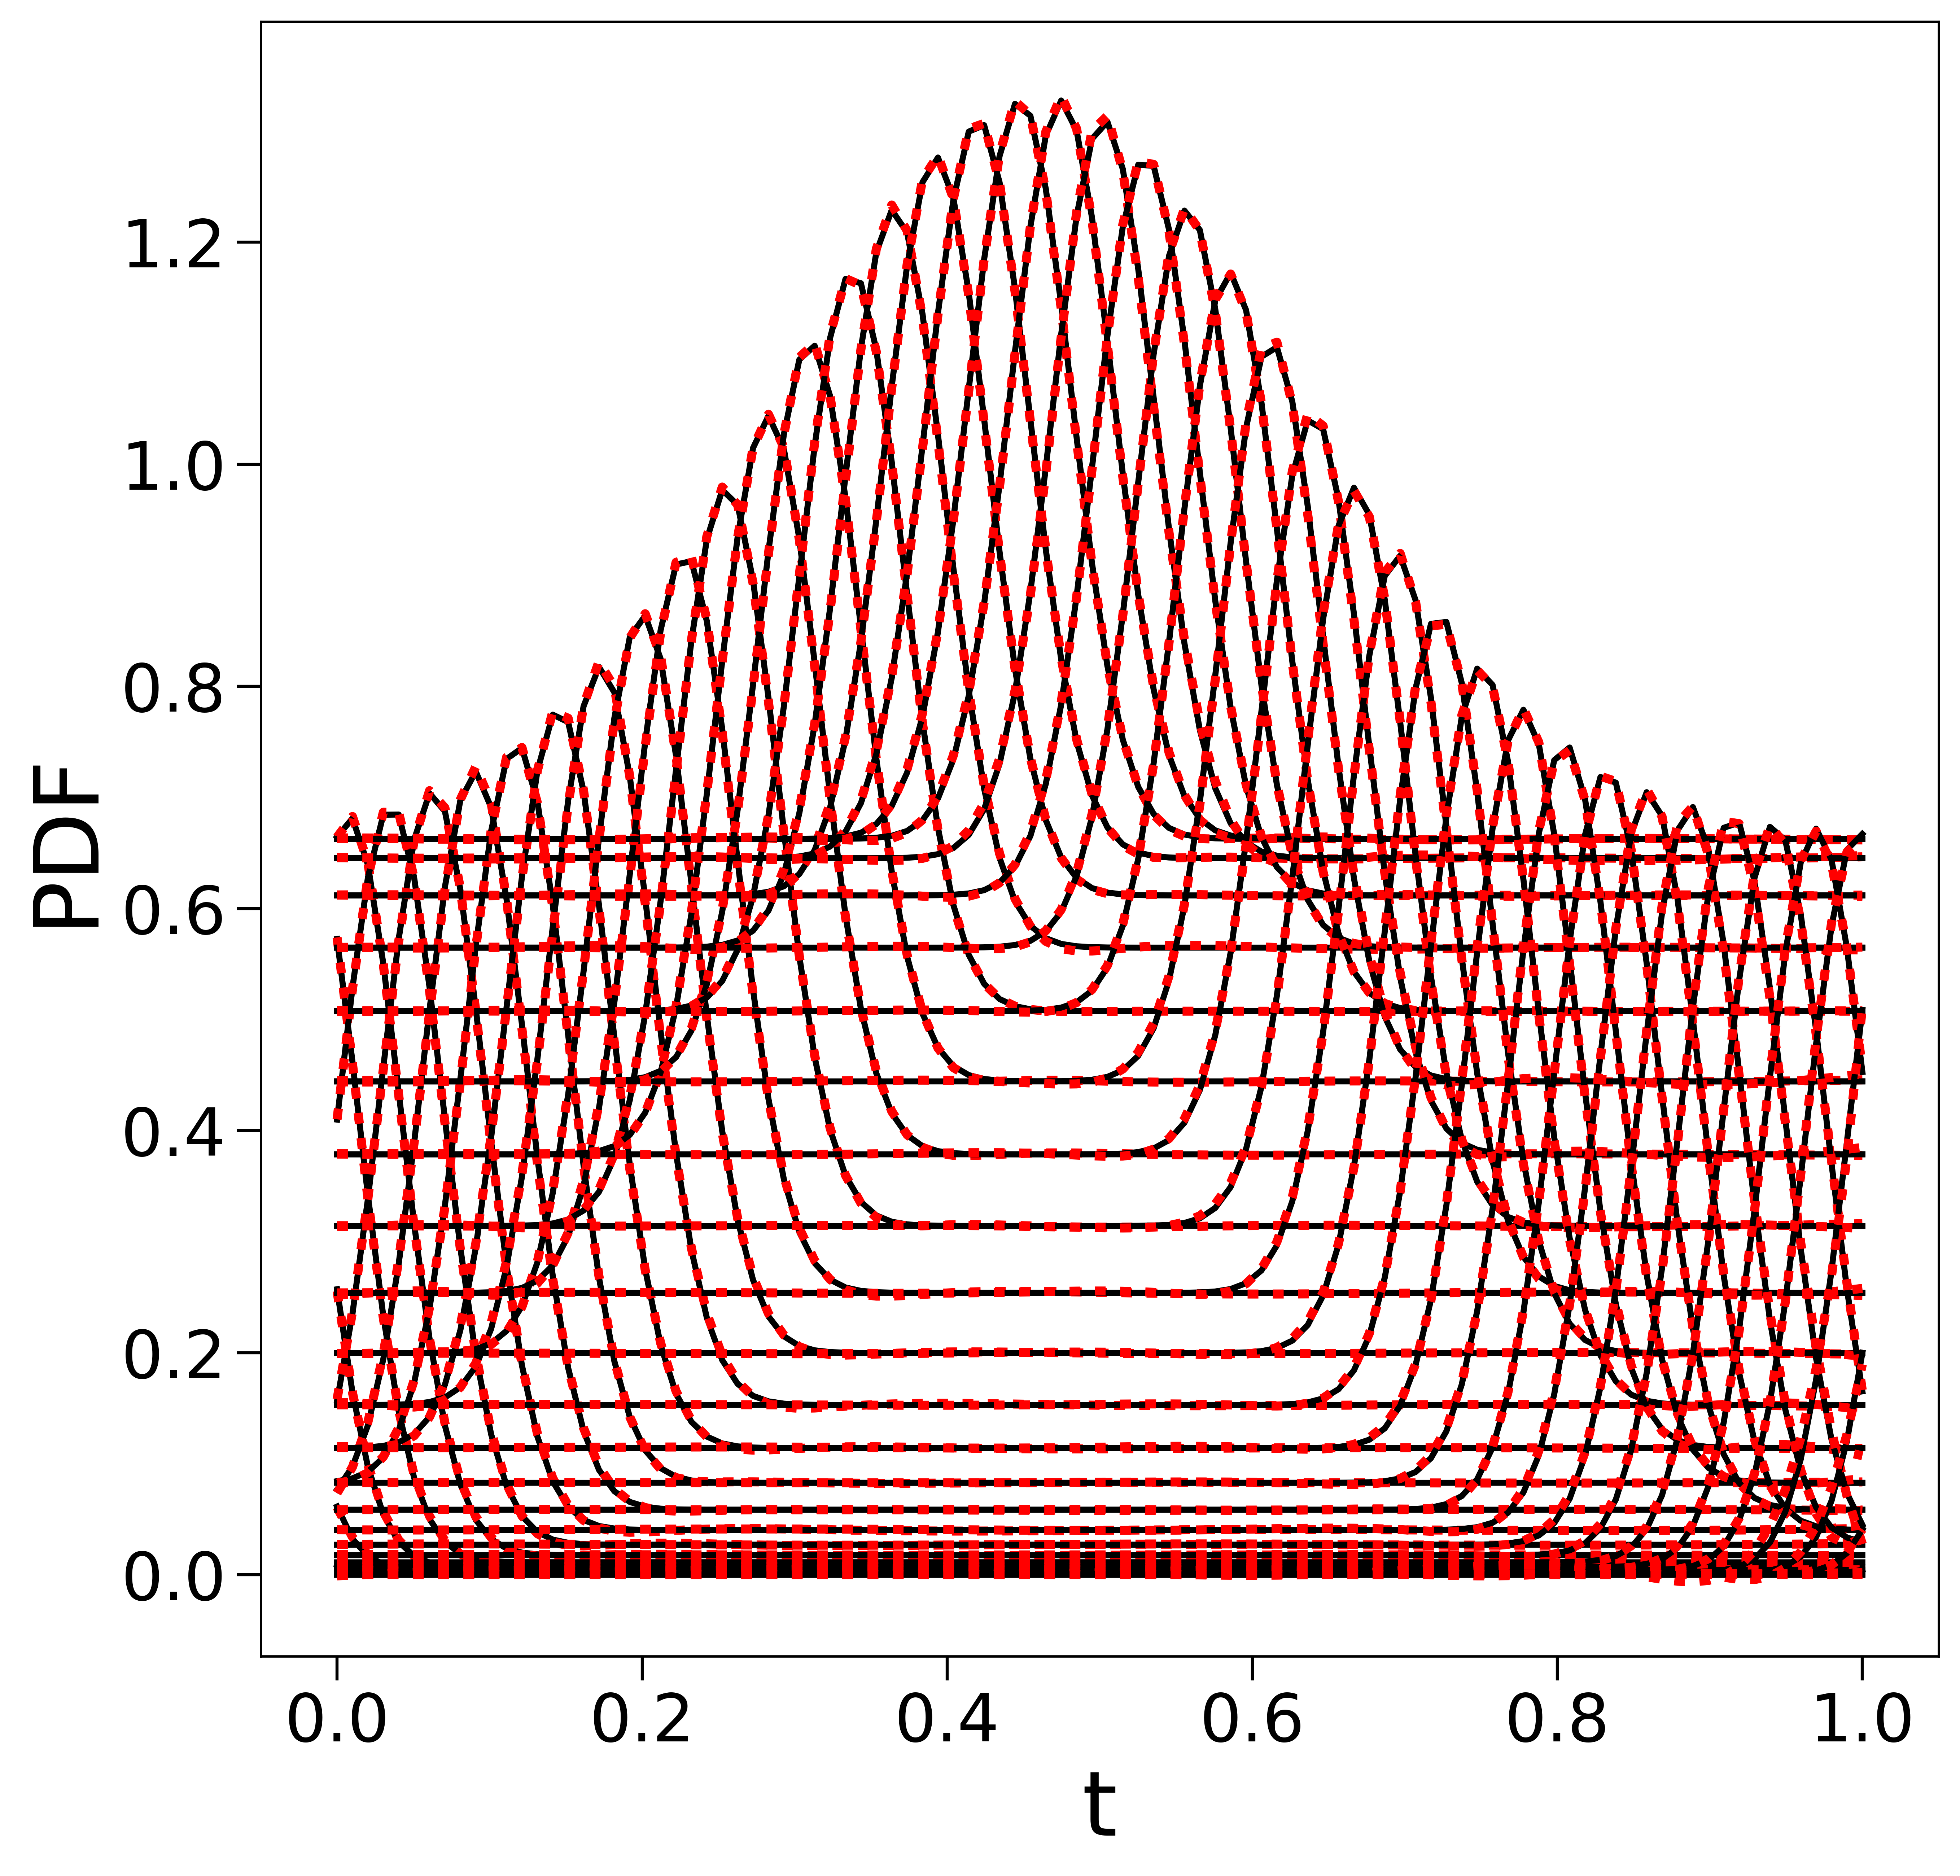

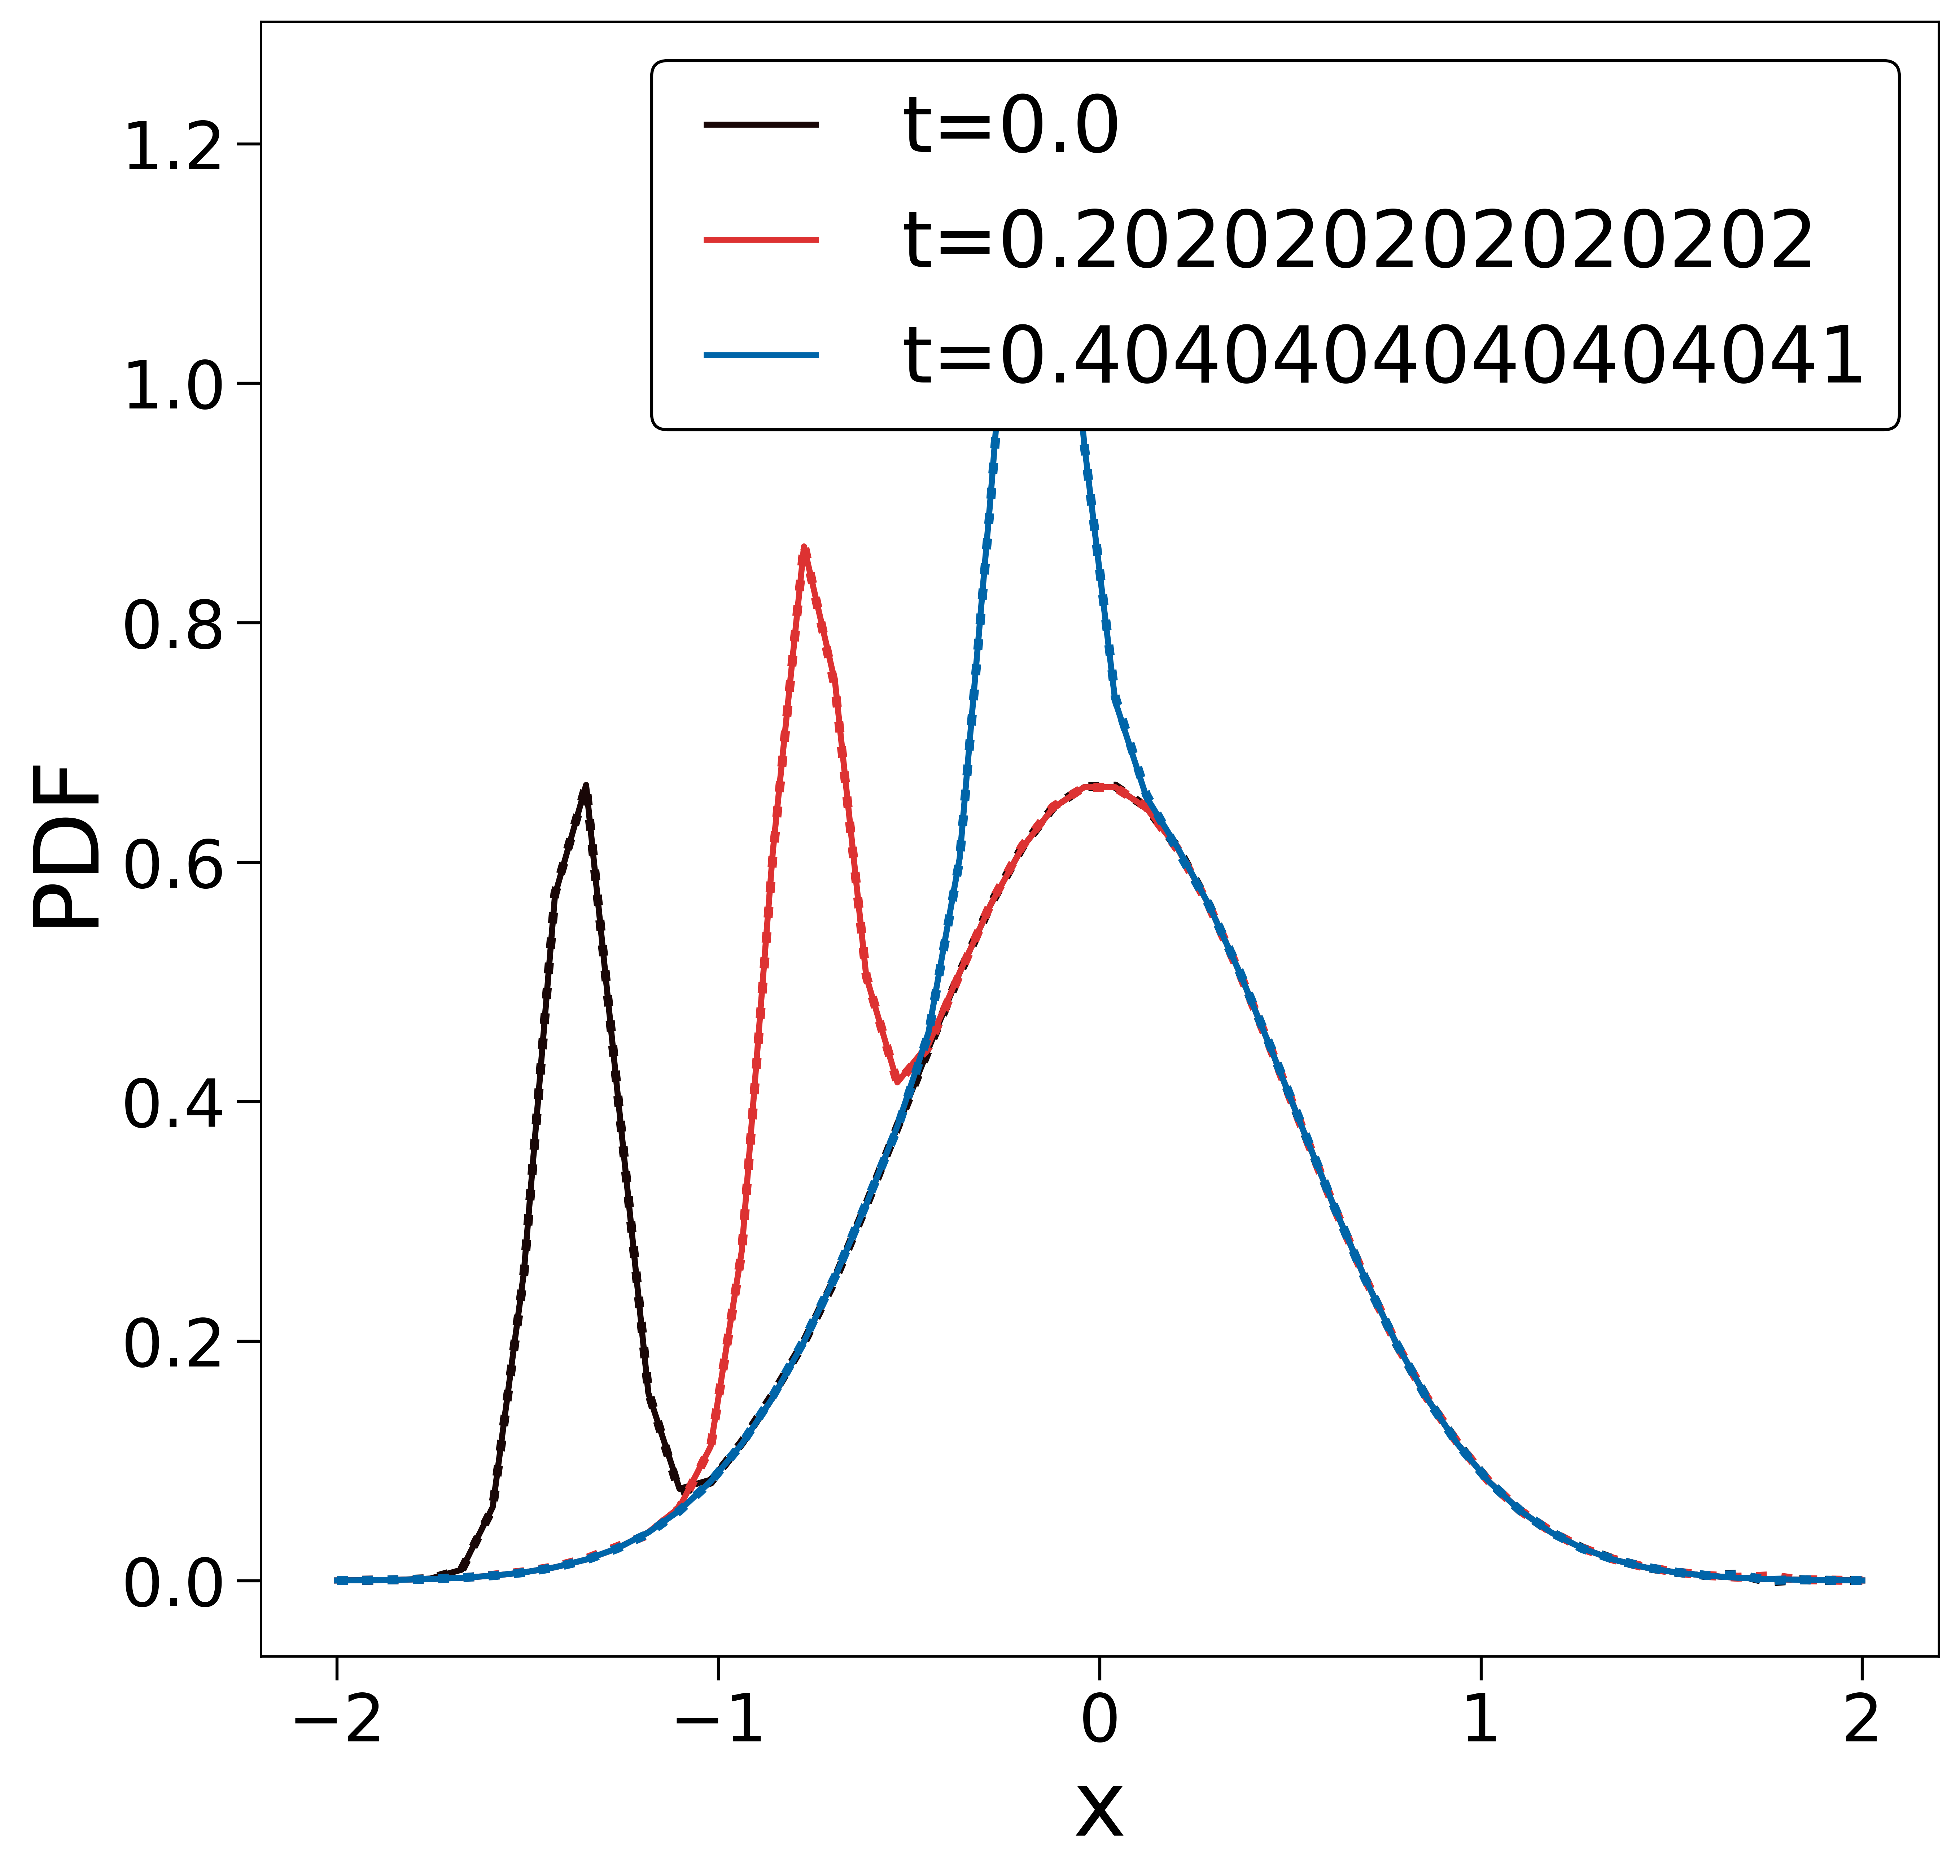

In [13]:
for iCase in [3]:#CasesVec:
    ax   = []
    fig  = []
    fig1 = plt.figure()
    fig.append(fig1)
    ax.append(plt.axes())
    fig2 = plt.figure()
    fig.append(fig2)
    ax.append(plt.axes())
    

    Data      = pd.read_csv(DataDir+'/Orig/test/ext/y.csv.'+str(iCase+1))
    
    x_t       = Data[x_names]
    t         = Data['t']

    x_t_pred  = pd.DataFrame(model.predict(Data[InputVars]), columns=x_names) 

    
    for i in range(NVars):
        ax[0].plot(t, x_t['x_'+str(i+1)],      '-k', linewidth=2)
        ax[0].plot(t, x_t_pred['x_'+str(i+1)], ':r')
        
    for jt, it in enumerate([0,20,40]):
        ax[1].plot(x, x_t.to_numpy()[it,:],      '-', color=ColorVec[jt], linewidth=2, label='t='+str(t[it]))
        ax[1].plot(x, x_t_pred.to_numpy()[it,:], ':', color=ColorVec[jt])

    ax[0].set_xlabel('t')
    ax[0].set_ylabel('PDF')
    
    ax[1].legend()
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('PDF')
    
    if (FigDir):
        fig[0].savefig(FigDir+'/EvolvePDF_All.eps', format='eps', bbox_inches='tight')
        fig[1].savefig(FigDir+'/EvolvePDF_ft.eps',  format='eps', bbox_inches='tight')

## Plotting Loss Histories

In [ ]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Trunk's Outputs

In [ ]:
iTrunk           = 2
iTest            = 0

FileName         = DataDir+'/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
Data             = pd.read_csv(FileName, header=0)

fig = plt.figure()
plt.plot(Data['t'], Data['x_'+str(iTrunk+1)])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$x_{'+str(iTrunk+1)+'}$')



iVarVec = range(0,4,1)

tVecTot = np.linspace(0.,1.,100)

output_ = model.net.system_of_components['DeepONet'].components['Trunk_'+str(iTrunk+1)].call(tVecTot[...,np.newaxis], model.net.layers_dict, None, training=False)

fig = plt.figure()

for iVar in iVarVec:

    plt.plot(tVecTot, output_[:,iVar])

#plt.xlim([1.e-6, 1.e-2])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+str(iTrunk+1)+'_{i}}$')

## Evaluating Branches' Outputs

In [ ]:
# FileName     = DataDir + '/Orig/train/ext/SimIdxs.csv'
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)


# FileName     = DataDir + '/Orig/train/ext/ICs.csv'
# Data         = pd.read_csv(FileName)
# ICVecs       = Data.to_numpy()
# n_ics        = len(ICVecs)
n_ics         = 10

Cols   = []
NewFlg = True
for iC in range(n_ics):

    try:
        FileName             = DataDir+'/Orig/'+DataType+'/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)

        DataICTemp           = Data[['x_'+str(i+1) for i in range(50)]].iloc[0]

        if (NewFlg):
            DataIC           = DataICTemp
            NewFlg           = False
        else:
            DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    except:
        pass

tVec              = Data['t']
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

DataIC.head()

In [ ]:
iBranch = 0
iVar    = 3



output_ = model.net.system_of_components['DeepONet'].components['Branch_'+str(iBranch+1)].call(DataIC.to_numpy(), model.net.layers_dict, None, training=False)



#%matplotlib qt

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(DataIC['x_1'], DataIC['x_2'], output_[:,iVar], c='r')
ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

## Evaluating Rigid Block + Trunk's Outputs

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


output_ = model.net.system_of_components['DeepONet'].components['Shift'].call(DataIC.to_numpy(), model.net.layers_dict, None, training=False)
#output_ = np.log(1. + np.exp(output_))

for iBranch in range(50):
    #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
    ax.scatter(DataIC['x_1'], DataIC['x_2'], output_[:,iBranch], label=r'$j='+str(iBranch+1)+'$')

ax.set_xlabel('\n'+r'$\eta_{1_0}$', rotation = 0)
ax.set_ylabel(r'           $\eta_{2_0}$', rotation = 0)
ax.set_zlabel(r'         $\log(\bar{t}_j)$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.legend()
#ax.set_zscale('log')

#if (FigDir):
#    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput.eps', format='eps', bbox_inches='tight')

In [ ]:
# fig = plt.figure(figsize=(10,10))
# ax  = fig.add_subplot(projection='3d')


# output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), training=False)

# output_.shape

# for iBranch in range(7,14):
#     #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
#     ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$\eta_{'+str(iBranch+1)+'}$')


# ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
# ax.set_zlabel(r'$\log(\bar{t})$')
# ax.legend()
# #ax.set_zscale('log')

In [ ]:
iVec   = [0,1]
Vars   = ['x_'+str(i+1) for i in range(50)]

for i in iVec:

    NewFlg   = True
    fig, ax1 = plt.subplots()
    ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    for iTest in CasesVec:
        
        FileName         = DataDir+'/Orig/test/ext/y.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        y_Data           = Data[Vars].to_numpy()
        #Data0            = Data[Data['t'] == 0.][Vars]
#         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
#         yPre_Data        = yPCA_Data.dot(A)
#         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
#         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

        if NewFlg:
            Label1 = 'ODE'
            Label2 = 'Rigid Block Prepr.'
            NewFlg = False
        else:
            Label1 = None
            Label2 = None

    
        ax1.plot(tVec, y_Data[:,i], color=ColorVec[0], label=Label1)

        ax2.plot(tVec*output_[iTest,i], y_Data[:,iPC], color=ColorVec[1], label=Label2)

    #plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])
    
    color = ColorVec[0]
    ax1.set_xlabel(r't', size=34)
    ax1.set_ylabel(r'$x_'+str(i+1)+'$', color=color, size=34)
    ax1.tick_params(axis='y', labelcolor=color)

    color = ColorVec[1]
    ax2.set_xlabel(r'$t-\bar{t_{'+str(i+1)+'})$', color=color, size=34)  # we already handled the x-label with ax1
    #ax2.set_ylabel(r'$x$', color=color, size=34)
    ax2.tick_params(axis='x', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.legend(loc=4)
    
    
#    if (FigDir):
#        plt.savefig(FigDir+'/0DReact_test_DeepONet_x'+str(i+1)+'_Shift.eps', format='eps', bbox_inches='tight')

In [ ]:
Vars